# Imports

In [1]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

Data Loading and Feature Engineering
------------------------------------
Let's use pandas to load a copy of the titanic dataset. We will apply some
preprocessing to encode the categorical features and fill missing values.

We further include two random variables that are not correlated in any way
with the target variable (``survived``):

- ``random_num`` is a high cardinality numerical variable (as many unique
  values as records).
- ``random_cat`` is a low cardinality categorical variable (3 possible
  values).

In [2]:


X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
rng = np.random.RandomState(seed=42)
X["random_cat"] = rng.randint(3, size=X.shape[0])
X["random_num"] = rng.randn(X.shape[0])

categorical_columns = ["pclass", "sex", "embarked", "random_cat"]
numerical_columns = ["age", "sibsp", "parch", "fare", "random_num"]

X = X[categorical_columns + numerical_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


In [3]:
categorical_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1
)
numerical_pipe = SimpleImputer(strategy="mean")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ],
    verbose_feature_names_out=False,
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=42, oob_score=True)),
    ]
)
rf.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


Accuracy of the Model


In [4]:
print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")

RF train accuracy: 1.000
RF test accuracy: 0.814


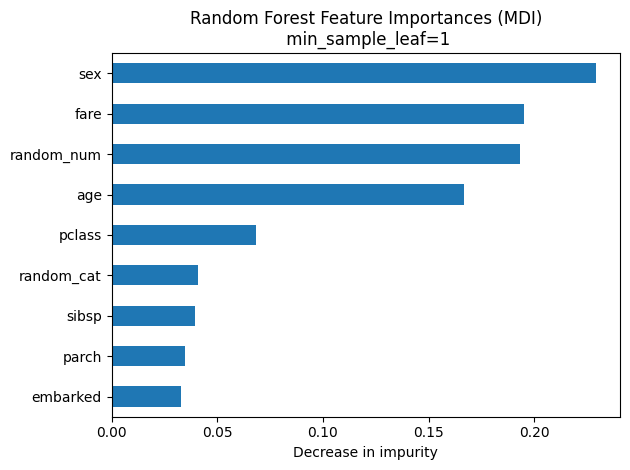

In [5]:
feature_names = rf[:-1].get_feature_names_out()

mdi_importances_1 = pd.Series(
    rf[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

ax = mdi_importances_1.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)\n min_sample_leaf=1")
ax.set_xlabel("Decrease in impurity")
ax.figure.tight_layout()

We can see that the uninformative features `random_num` and `random_cat` receive significant importance despite being unrelated to the target.

To see how this problem relates to overfitting, we can set `min_samples_leaf` at 20
data points to reduce the overfitting of the model.

In [6]:
rf.set_params(classifier__min_samples_leaf=20).fit(X_train, y_train)
print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")


RF train accuracy: 0.810
RF test accuracy: 0.832


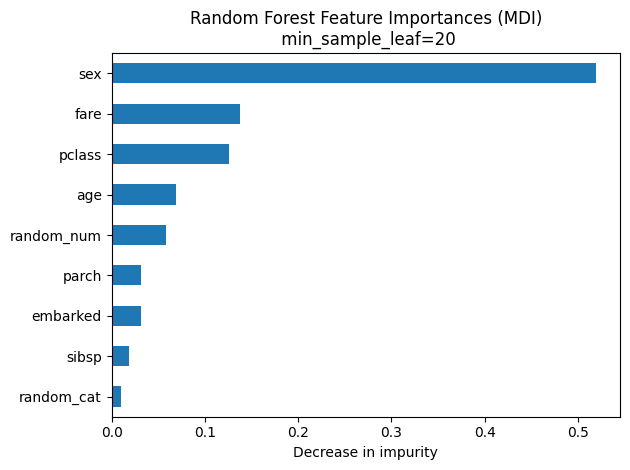

In [7]:
mdi_importances_20 = pd.Series(
    rf[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

ax = mdi_importances_20.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)\n min_sample_leaf=20")
ax.set_xlabel("Decrease in impurity")
ax.figure.tight_layout()